---
title: "Airline Passenger Satisfaction"
subtitle: "Clustering and Multivariate Visualization with `python`"
author: "solar-san"
date-modified: "2023-11-20"
format:
  html:
    theme: github
    toc: true
    toc-location: right
    fig-align: center
    fig-width: 8
    fig-height: 8
    html-math-method: katex
    code-overflow: scroll
    code-copy: hover
    highlight-style: arrow
    citations-hover: true
    footnotes-hover: true
    header-includes: |
      <meta name="author" content="solar-san">
      <meta 
      name="description" 
      content="">
      <link rel="preconnect" href="https://fonts.googleapis.com">
      <link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
      <link href="https://fonts.googleapis.com/css2?family=Atkinson+Hyperlegible:ital,wght@0,400;0,700;1,400;1,700&family=Fira+Code&display=swap" rel="stylesheet">
mainfont: "Atkinson Hyperlegible"
monofont: 'Fira Code'
---

![](figures/Kaggle-airplane_passenger_header.png)

The scope of this notebook is to practice _interactive visualizations_ with plotly, by exploring data about the satisfaction of passengers through a set of variable: this will pose the main challenge, however, as only 2-D or 3-D visualizations are possible.

> This implies that, in addition to common visualization techniques, _dimensionality reduction_ is required to obtain the desidered visual insights.

# Imports

:::{.callout-tip}
To download the dataset directly from Kaggle, uncomment the following code cell.
:::

In [1]:
#!/bin/sh kaggle datasets download -d teejmahal20/airline-passenger-satisfaction

Loading all the necessary libraries and setting `plotly` options to customize graphs and allow interactivity in the HTML render:

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
# import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import shutil


from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


pio.templates.default = "plotly_white"

pio.renderers.default = 'iframe_connected'
np.set_printoptions(precision=3)

I wish to keep a tidy directory, hence I will delete the unzipped datasets after they have been loaded in memory:

In [3]:
data_path = Path("data/")

In [6]:
with zipfile.ZipFile(
    data_path / "airline-passenger-satisfaction.zip",
    'r'
) as zip_ref:
    zip_ref.extractall(data_path / "unzipped/")

train = pd.read_csv(
    data_path / "unzipped/train.csv"
)
test = pd.read_csv(
    data_path / "unzipped/test.csv"
)
shutil.rmtree(
    data_path / "unzipped/"
)

# Data cleaning and preparation

In [4]:
passengers_df = train

In [5]:
passengers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [6]:
passengers_df.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## Variables description

These are the variables we will be dealing with:

1. Categorical variables:
    - `Gender`: gender of the passengers (Female, Male)
    - `Customer Type`: The customer type (Loyal customer, disloyal customer)
    - `Type of Travel`: purpose of the flight of the passengers (Personal Travel, Business Travel)
    - `Class`: travel class in the plane of the passengers (Business, Eco, Eco Plus)
    - `Satisfaction`: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)
2. Numerical variables:
    - `Age`: the actual age of the passengers
    - `Flight distance`: the flight distance of this journey
    - `Inflight wifi service`: satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
    - `Departure/Arrival time convenient`: satisfaction level of Departure/Arrival time convenient
    - `Ease of Online booking`: satisfaction level of online booking
    - `Gate location`: satisfaction level of Gate location
    - `Food and drink`: satisfaction level of Food and drink
    - `Online boarding`: satisfaction level of online boarding
    - `Seat comfort`: satisfaction level of Seat comfort
    - `Inflight entertainment`: satisfaction level of inflight entertainment
    - `On-board service`: satisfaction level of On-board service
    - `Leg room service`: satisfaction level of Leg room service
    - `Baggage handling`: satisfaction level of baggage handling
    - `Check-in service`: satisfaction level of Check-in service
    - `Inflight service`: satisfaction level of inflight service
    - `Cleanliness`: satisfaction level of Cleanliness
    - `Departure Delay in Minutes`: Minutes delayed when departure
    - `Arrival Delay in Minutes`: Minutes delayed when Arrival

## Data cleaning

1. Removing unnecessary variables.

In [7]:
passengers_df.drop(
    [
        "Unnamed: 0",
        "id"
    ],
    axis=1,
    inplace=True
)

2. Transforming categorical variables.



In [8]:
passengers_df = pd.get_dummies(
    passengers_df,
    dtype="float",
    prefix="",
    prefix_sep=""
)

In [9]:
passengers_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
0,13,460,3,4,3,1,5,3,5,5,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,25,235,3,2,3,3,1,3,1,1,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,26,1142,2,2,2,2,5,5,5,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,25,562,2,5,5,5,2,2,2,2,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,61,214,3,3,3,3,4,5,5,3,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
passengers_df.dropna(
    inplace=True
)

# PCA

In [11]:
passengers_2d = PCA(
    n_components=2,
)
passengers_2d.fit(passengers_df)

PCA(n_components=2)

In [12]:
passengers_2d.explained_variance_ratio_.sum()

0.9996962403495984

In [13]:
df_reduced_2d = passengers_2d.transform(passengers_df)

fig = px.scatter(
    df_reduced_2d[:, 0],
    y = df_reduced_2d[:, 1]
    )

fig.show()

In [14]:
df_reduced_2d = passengers_2d.transform(passengers_df)

fig = px.scatter(
    x = df_reduced_2d[:, 0], 
    y = df_reduced_2d[:, 1]
    )

fig.show();

In [15]:
downsampling_idx = df_reduced_2d[
    np.random.choice(
        df_reduced_2d.shape[0],
        1000,
        replace=False
        )
    ]

px.scatter(
    x = downsampling_idx[:, 0], 
    y = downsampling_idx[:, 1]
)

---

I am not sure that this visualization helps. Further down I will try and add colors corresponding to the clusters, to see if this is helpful or not.

# $K$-Means

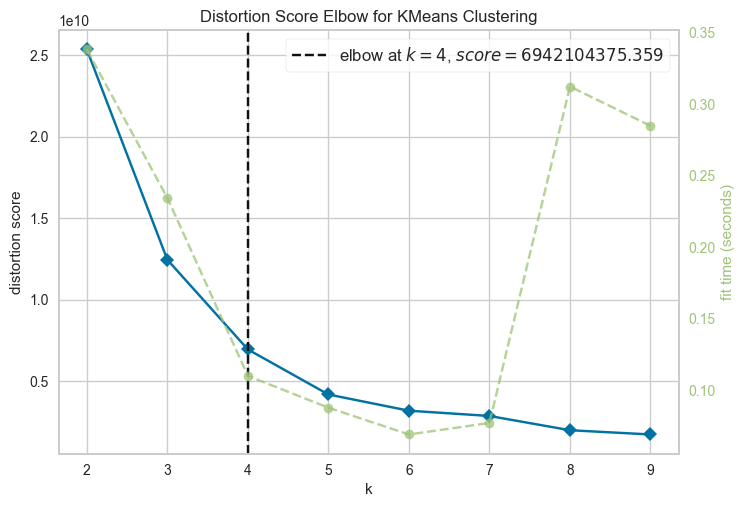

In [16]:
model = KMeans(
    n_init = 'auto',
    random_state = 19
)

elbow_2 = KElbowVisualizer(model, k = (2, 10))

elbow_2.fit(df_reduced_2d)

elbow_2.show();

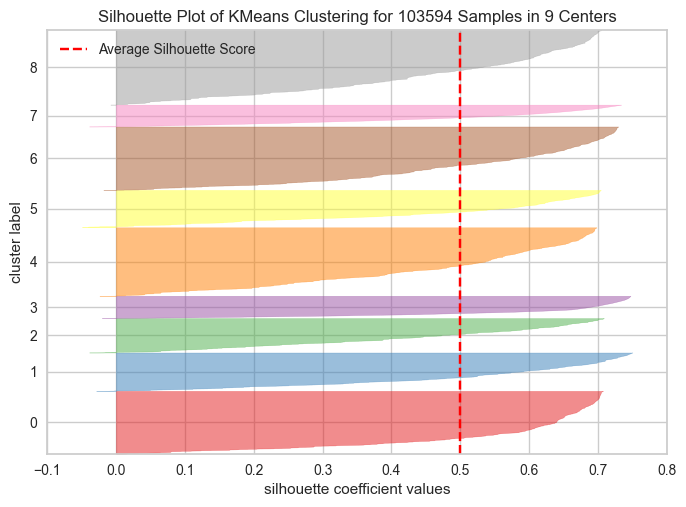

In [17]:
silhouette = SilhouetteVisualizer(model)
silhouette.fit(df_reduced_2d)
silhouette.show();

## $K = 4$

In [18]:
km_4 = KMeans(
    n_clusters = 4,
    n_init = 'auto',
    random_state = 19
)

km_4.fit(
    df_reduced_2d,
)


KMeans(n_clusters=4, n_init='auto', random_state=19)

In [19]:
y_km_4 = km_4.predict(df_reduced_2d).astype(pd.Categorical)

fig = px.scatter(
    x = df_reduced_2d[:, 0], 
    y = df_reduced_2d[:, 1], 
    color=y_km_4,
    opacity=.7,
    color_discrete_sequence=px.colors.qualitative.Bold
    )

fig.show()   

---

The clustering algo worked also in this situation with a good performance. Seems like if I follow the insight given by the _Elbow method_, it affects positively the computation time.

In [20]:
km_4 = KMeans(
    n_clusters = 4,
    n_init = 'auto',
    random_state = 19
)

%timeit km_4.fit(df_reduced_2d)

89.1 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Further testing is needed on the whole processing chain. However, there is an important aspect left that needs more study to be understood. 

I need a way to visualize the clusters. This can be done easily since the output of the `predict` methods allows me to obtain a `Series` of labels. This means that I can use that information as a __grouping label__ and apply a `mean` method to the resulting group to obtain a syntethic rapresentation of the __KMC__ ($K$-th Mean Customer). I only need to:

- Create a df with the results and use that for the grouping variables.
- Create an array that contains both the resulting compressed data from the PCA 2D and the corresponding labels; _then_ I can downsample the dataset and tranform it to better visualize the clusters. This ensures that all the labels and shapes fit together.

In [21]:


downsampling_idx = df_reduced_2d[np.random.choice(df_reduced_2d.shape[0], 1000, replace=False)]

fig = px.scatter(
    x = downsampling_idx[:, 0], 
    y = np.log(
        downsampling_idx[:, 1]
        )
    )
fig.show();

/var/folders/mm/nzts_rm10vzfv61dt475_5xh0000gp/T/ipykernel_2800/952221750.py:5: RuntimeWarning:

invalid value encountered in log



In [22]:
viz_df_2D = pd.DataFrame(
    {"dim1": df_reduced_2d[:, 0],
     "dim2": df_reduced_2d[:, 1],
     "labels": y_km_4
    }
)

downsampling_idx = viz_df_2D.sample(n = 5000, axis=0)

fig = px.scatter(
    downsampling_idx, 
    x = downsampling_idx.dim1, 
    y = np.log(
        downsampling_idx.dim2
    ),
    color=downsampling_idx.labels,
    color_discrete_sequence=px.colors.qualitative.Bold
    )
    
    
fig.show();

/Users/themagician/py-venv/kaggle-venv/env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log



# Code for the $K$-Mean Customer summary table

What does the _average_ customer belonging to each cluster look like?

In [23]:
pd.concat(
    [
        pd.DataFrame(
            passengers_2d.inverse_transform(
                df_reduced_2d
                )
            ), pd.DataFrame(
                {"labels":y_km_4}
                )
            ],
    axis=1
    ).rename(
        columns = dict(
            enumerate(
                passengers_df.columns
                )
            )
        ).groupby(
            "labels"
            ).mean()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,Business,Eco,Eco Plus,neutral or dissatisfied,satisfied
labels,,,,,,,,,,,,,,,,,,,,,
0,38.207456,413.654018,2.722578,3.083697,2.685546,2.972292,3.143417,3.024760,3.278348,3.225134,...,0.490113,0.749514,0.250486,0.593556,0.406444,0.296662,0.606356,0.096982,0.681697,0.318303
1,40.925459,2208.460066,2.739686,3.029055,2.851054,2.983103,3.280129,3.547662,3.652638,3.534173,...,0.495576,0.906280,0.093720,0.816326,0.183674,0.716723,0.243923,0.039354,0.414832,0.585168
2,39.303757,1140.621560,2.728895,3.061561,2.752331,2.976843,3.197742,3.235862,3.428994,3.349323,...,0.492344,0.812965,0.187035,0.683856,0.316144,0.466645,0.459680,0.073675,0.574282,0.425718
3,42.752586,3418.020789,2.750603,2.992226,2.962341,2.990559,3.371213,3.899364,3.903925,3.741459,...,0.499275,1.011882,-0.011882,0.966524,0.033476,0.999654,-0.000205,0.000551,0.235661,0.764339


In [24]:
passengers_2d

PCA(n_components=2)

In [25]:
passengers_2d.inverse_transform(passengers_df.shape)

array([ 1.960e+02,  1.048e+05,  3.689e+00, -9.398e-02,  1.230e+01,
        3.609e+00,  1.104e+01,  3.340e+01,  2.500e+01,  2.115e+01,
        1.802e+01,  2.165e+01,  1.138e+01,  1.292e+01,  1.062e+01,
        1.597e+01,  4.263e+01,  2.609e+01,  1.914e-01,  8.086e-01,
        9.863e+00, -8.863e+00,  1.355e+01, -1.255e+01,  2.472e+01,
       -2.046e+01, -3.253e+00, -1.481e+01,  1.581e+01])

In [26]:
pd.DataFrame({"labels":y_km_4})

,labels
0,0
1,0
2,2
3,0
4,0
...,...
103589,0
103590,1
103591,1
103592,2


In [27]:
passengers_df.shape

(103594, 29)

In [28]:
passengers_2d.inverse_transform(df_reduced_2d).shape

(103594, 29)

In [29]:
dict(enumerate(passengers_df.columns))

{0: 'Age',
 1: 'Flight Distance',
 2: 'Inflight wifi service',
 3: 'Departure/Arrival time convenient',
 4: 'Ease of Online booking',
 5: 'Gate location',
 6: 'Food and drink',
 7: 'Online boarding',
 8: 'Seat comfort',
 9: 'Inflight entertainment',
 10: 'On-board service',
 11: 'Leg room service',
 12: 'Baggage handling',
 13: 'Checkin service',
 14: 'Inflight service',
 15: 'Cleanliness',
 16: 'Departure Delay in Minutes',
 17: 'Arrival Delay in Minutes',
 18: 'Female',
 19: 'Male',
 20: 'Loyal Customer',
 21: 'disloyal Customer',
 22: 'Business travel',
 23: 'Personal Travel',
 24: 'Business',
 25: 'Eco',
 26: 'Eco Plus',
 27: 'neutral or dissatisfied',
 28: 'satisfied'}

In [30]:
0.680471 + 0.319529

1.0